In [0]:
!pip install --upgrade tables
!pip install eli5
!pip install xgboost
!pip install hyperopt

     |████████████████████████████████| 4.3MB 3.4MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 3.5MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, KFold

import eli5
from eli5.sklearn import PermutationImportance

from hyperopt import hp, fmin, tpe, STATUS_OK

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
cd "/content/drive/My Drive/Colab Notebooks/smog"

/content/drive/My Drive/Colab Notebooks/smog


In [0]:
ls data

data_pm25_plus_darksky.csv


In [0]:
df = pd.read_csv('data/data_pm25_plus_darksky.csv')

In [0]:
df.shape

(43853, 31)

In [0]:
df.head()

,Unnamed: 0,date,pm25_nie,pm25_kon,pm25_wok,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed,year,month,day,hour,day_of_week,no_of_week,winter_break
0,0,2015-01-01 00:00:00,51.5034,78.085,51.320000,32.93,1.0,29.56,0.87,NaN,NaN,0.0,0.0,0.0,NaN,1027.7,NaN,32.93,1.420067e+09,0.0,2.733,260.0,6.93,6.93,2015,1,1,0,4,1,0
1,1,2015-01-01 01:00:00,71.8204,78.085,68.982316,33.90,1.0,31.11,0.89,NaN,NaN,0.0,0.0,0.0,NaN,1027.7,NaN,33.90,1.420070e+09,0.0,2.733,260.0,6.93,6.93,2015,1,1,1,4,1,0
2,2,2015-01-01 02:00:00,42.6996,64.460,48.707108,27.73,1.0,31.59,0.91,cloudy,NaN,0.0,0.0,0.0,NaN,1027.7,Overcast,33.81,1.420074e+09,0.0,2.733,260.0,6.93,6.93,2015,1,1,2,4,1,0
3,3,2015-01-01 03:00:00,38.2824,36.210,37.986883,27.73,1.0,32.76,0.96,fog,NaN,0.0,0.0,0.0,NaN,1027.7,Foggy,33.81,1.420078e+09,0.0,1.244,251.0,6.93,6.93,2015,1,1,3,4,1,0
4,4,2015-01-01 04:00:00,35.4194,29.585,33.675489,26.41,1.0,32.89,0.97,fog,NaN,0.0,0.0,0.0,NaN,1027.7,Foggy,33.73,1.420081e+09,0.0,1.152,251.0,8.96,8.96,2015,1,1,4,4,1,0


In [0]:
df.columns

Index(['Unnamed: 0', 'date', 'pm25_nie', 'pm25_kon', 'pm25_wok',
       'apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon',
       'ozone', 'precipAccumulation', 'precipIntensity', 'precipProbability',
       'precipType', 'pressure', 'summary', 'temperature', 'time', 'uvIndex',
       'visibility', 'windBearing', 'windGust', 'windSpeed', 'year', 'month',
       'day', 'hour', 'day_of_week', 'no_of_week', 'winter_break'],
      dtype='object')

In [0]:
#Usuwany niepotrzebne stacje
df.drop('pm25_kon', 'pm25_wok','Unnamed: 0', 'time','year', 'month', 'day', 'hour'], axis = 1, inplace = True)
df.head()

SyntaxError: ignored

In [0]:
df.isnull().sum()

pm25_nie                   0
apparentTemperature        0
cloudCover                 0
dewPoint                   0
humidity                   0
icon                    1634
ozone                  30340
precipAccumulation         0
precipIntensity            0
precipProbability          0
precipType             38411
pressure                   0
summary                 1634
temperature                0
time                       0
uvIndex                    0
visibility                 0
windBearing                0
windGust                   0
windSpeed                  0
year                       0
month                      0
day                        0
hour                       0
day_of_week                0
no_of_week                 0
winter_break               0
dtype: int64

In [0]:
df = df.dropna(1)
df.head()

,Suma,Udział
precipType,38411,0.875904
ozone,30340,0.691857
summary,1634,0.037261
icon,1634,0.037261
winter_break,0,0.000000
apparentTemperature,0,0.000000
cloudCover,0,0.000000
dewPoint,0,0.000000
humidity,0,0.000000
precipAccumulation,0,0.000000


EDA

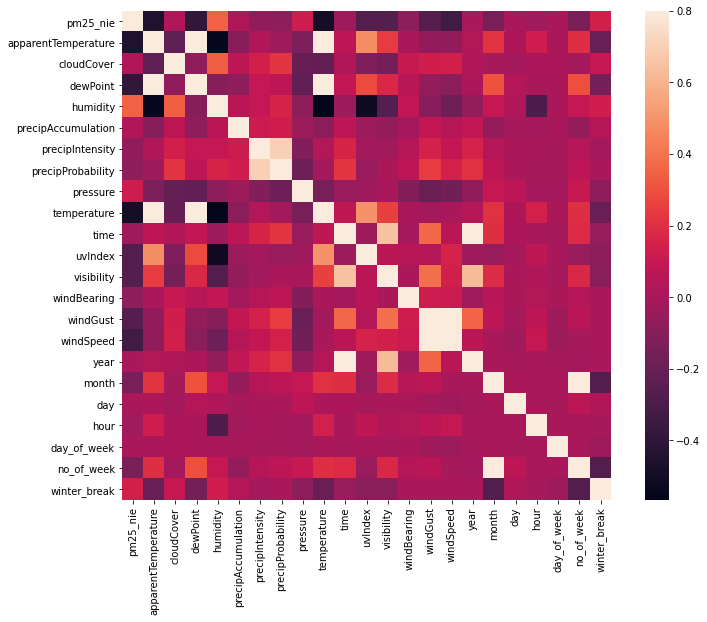

In [0]:
#Korelogram
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

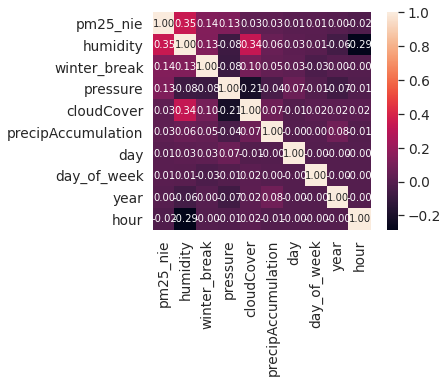

In [0]:
#9 najmocniej skorelowanych zmiennych ze zmienną objaśnianą
k = 10 #liczba zmiennych 
col = corrmat.nlargest(k, 'pm25_nie')['pm25_nie'].index
cm = np.corrcoef(df[col].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=col.values, xticklabels=col.values)
plt.show()

In [0]:
#Podział zbioru na zmienne objaśniające i zmienną objaśnianą
y = df['pm25_nie']
X = df.drop('pm25_nie', axis = 1)
X2 = df.drop('pm25_nie', axis = 1)

In [0]:
print(y.shape)
print(X.shape)

(43853,)
(43853, 22)


count    43853.000000
mean        25.296143
std         16.907685
min          0.877018
25%         13.535946
50%         20.661466
75%         31.902000
max        187.930147
Name: pm25_nie, dtype: float64


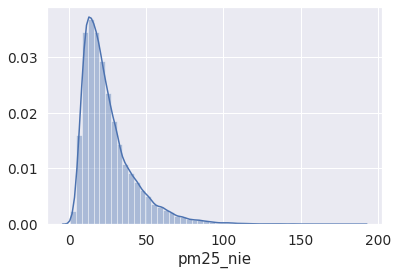

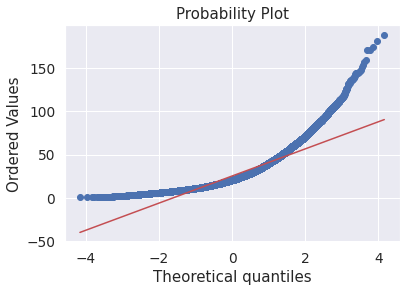

In [0]:
print(y.describe())
sns.distplot(y)
fig = plt.figure()
qq = stats.probplot(df['pm25_nie'], plot=plt)

In [0]:
#Transformacja logarytmiczna
y = np.log(y)

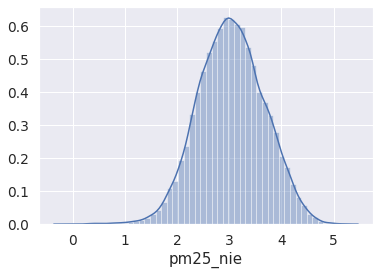

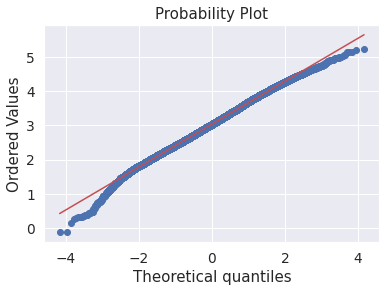

In [0]:
#Ponowna weryfikacja normalności
sns.distplot(y)
fig = plt.figure()
qq = stats.probplot(y, plot=plt)

standaryzacja

In [0]:
X.columns

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
       'precipAccumulation', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'time', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'windSpeed', 'year', 'month', 'day', 'hour',
       'day_of_week', 'no_of_week', 'winter_break'],
      dtype='object')

In [0]:
from sklearn import preprocessing
for a in X.columns:
  
  if X[a].dtypes != np.object and a != 'year' and a !=  'month' and a !=  'day' and a !=  'hour' and a != 'day_of_week' and a !=  'no_of_week' and a !=  'winter_break':
    X[a] = preprocessing.scale(X[a]) 

X.head()
X.describe()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


,apparentTemperature,cloudCover,dewPoint,humidity,precipAccumulation,precipIntensity,precipProbability,pressure,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed,year,month,day,hour,day_of_week,no_of_week,winter_break
count,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,43853.000000,43853.000000,43853.000000,43853.000000,43853.000000,43853.000000,43853.000000
mean,-1.847629e-17,-2.895496e-16,-1.090020e-16,2.294394e-15,-7.083655e-15,-6.509594e-14,4.999759e-15,8.254770e-15,9.400756e-16,3.168666e-17,1.399904e-15,-6.810260e-14,-2.320650e-16,-3.689729e-15,2.640251e-16,2017.000000,6.520922,15.721137,11.498917,3.999247,26.603402,0.034593
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.413843,3.450052,8.804220,6.922614,2.001259,15.069082,0.182748
min,-3.147765e+00,-1.758421e+00,-3.935043e+00,-3.352246e+00,-6.789831e-02,-1.558430e-01,-2.327410e-01,-4.674042e+00,-3.418411e+00,-1.732598e+00,-5.426105e-01,-3.042833e+00,-2.063590e+00,-1.453863e+00,-1.904293e+00,2015.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,-8.194306e-01,-9.948313e-01,-7.023136e-01,-6.942047e-01,-6.789831e-02,-1.558430e-01,-2.327410e-01,-5.815254e-01,-7.915178e-01,-8.659688e-01,-5.426105e-01,-3.014945e-01,-8.384223e-01,-7.306604e-01,-7.198373e-01,2016.000000,4.000000,8.000000,5.000000,2.000000,14.000000,0.000000
50%,-2.779711e-02,4.407168e-01,5.549681e-04,1.918090e-01,-6.789831e-02,-1.558430e-01,-2.327410e-01,6.349866e-03,-5.222371e-02,7.395624e-04,-5.426105e-01,-3.010489e-01,1.310582e-01,-2.607193e-01,-1.503876e-01,2017.000000,7.000000,16.000000,11.000000,4.000000,27.000000,0.000000
75%,8.072281e-01,8.988704e-01,8.027250e-01,8.009434e-01,-6.789831e-02,-1.558430e-01,-2.327410e-01,6.394463e-01,7.774832e-01,8.655504e-01,8.579224e-02,1.384832e+00,8.128905e-01,4.441924e-01,5.835698e-01,2018.000000,10.000000,23.000000,17.000000,6.000000,40.000000,0.000000
max,2.574645e+00,1.295937e+00,2.281387e+00,1.520830e+00,5.015122e+01,4.719272e+01,1.009697e+01,3.409243e+00,2.832376e+00,1.732259e+00,4.484611e+00,1.384832e+00,1.761064e+00,5.811933e+00,7.910489e+00,2019.000000,12.000000,31.000000,23.000000,7.000000,53.000000,1.000000


In [0]:
for a in X2.columns:
  
  if X2[a].dtypes != np.object:
    X2[a] = preprocessing.scale(X2[a]) 

X2.head()
X2.describe()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


,apparentTemperature,cloudCover,dewPoint,humidity,precipAccumulation,precipIntensity,precipProbability,pressure,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed,year,month,day,hour,day_of_week,no_of_week,winter_break
count,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04,4.385300e+04
mean,-1.847629e-17,-2.895496e-16,-1.090020e-16,2.294394e-15,-7.083655e-15,-6.509594e-14,4.999759e-15,8.254770e-15,9.400756e-16,3.168666e-17,1.399904e-15,-6.810260e-14,-2.320650e-16,-3.689729e-15,2.640251e-16,2.670429e-17,-1.589910e-14,1.232195e-15,1.734716e-16,-5.145918e-17,6.288612e-15,-2.866426e-14
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-3.147765e+00,-1.758421e+00,-3.935043e+00,-3.352246e+00,-6.789831e-02,-1.558430e-01,-2.327410e-01,-4.674042e+00,-3.418411e+00,-1.732598e+00,-5.426105e-01,-3.042833e+00,-2.063590e+00,-1.453863e+00,-1.904293e+00,-1.414601e+00,-1.600262e+00,-1.672074e+00,-1.661085e+00,-1.498697e+00,-1.699088e+00,-1.892944e-01
25%,-8.194306e-01,-9.948313e-01,-7.023136e-01,-6.942047e-01,-6.789831e-02,-1.558430e-01,-2.327410e-01,-5.815254e-01,-7.915178e-01,-8.659688e-01,-5.426105e-01,-3.014945e-01,-8.384223e-01,-7.306604e-01,-7.198373e-01,-7.073004e-01,-7.306995e-01,-8.769913e-01,-9.388059e-01,-9.990061e-01,-8.363845e-01,-1.892944e-01
50%,-2.779711e-02,4.407168e-01,5.549681e-04,1.918090e-01,-6.789831e-02,-1.558430e-01,-2.327410e-01,6.349866e-03,-5.222371e-02,7.395624e-04,-5.426105e-01,-3.010489e-01,1.310582e-01,-2.607193e-01,-1.503876e-01,0.000000e+00,1.388626e-01,3.167420e-02,-7.207141e-02,3.760246e-04,2.631894e-02,-1.892944e-01
75%,8.072281e-01,8.988704e-01,8.027250e-01,8.009434e-01,-6.789831e-02,-1.558430e-01,-2.327410e-01,6.394463e-01,7.774832e-01,8.655504e-01,8.579224e-02,1.384832e+00,8.128905e-01,4.441924e-01,5.835698e-01,7.073004e-01,1.008425e+00,8.267565e-01,7.946631e-01,9.997581e-01,8.890224e-01,-1.892944e-01
max,2.574645e+00,1.295937e+00,2.281387e+00,1.520830e+00,5.015122e+01,4.719272e+01,1.009697e+01,3.409243e+00,2.832376e+00,1.732259e+00,4.484611e+00,1.384832e+00,1.761064e+00,5.811933e+00,7.910489e+00,1.414601e+00,1.588133e+00,1.735422e+00,1.661398e+00,1.499449e+00,1.751726e+00,5.282775e+00


onehotencoding

In [0]:
dummy_df = pd.get_dummies(X)

In [0]:
dummy_df2 = pd.get_dummies(X2)

https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.get_dummies.html



columns : list-like, default None

    Column names in the DataFrame to be encoded. If columns is None then all the columns with object or category dtype will be converted.


In [0]:
print(X.columns)
print(dummy_df.columns)

print(dummy_df.dtypes)

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
       'precipAccumulation', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'time', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'windSpeed', 'year', 'month', 'day', 'hour',
       'day_of_week', 'no_of_week', 'winter_break'],
      dtype='object')
Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
       'precipAccumulation', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'time', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'windSpeed', 'year', 'month', 'day', 'hour',
       'day_of_week', 'no_of_week', 'winter_break'],
      dtype='object')
apparentTemperature    float64
cloudCover             float64
dewPoint               float64
humidity               float64
precipAccumulation     float64
precipIntensity        float64
precipProbability      float64
pressure               float64
temperature            float64
time 

In [0]:
dummy_df.isnull().sum()

apparentTemperature                                  0
cloudCover                                           0
dewPoint                                             0
humidity                                             0
precipAccumulation                                   0
precipIntensity                                      0
precipProbability                                    0
pressure                                             0
temperature                                          0
time                                                 0
uvIndex                                              0
visibility                                           0
windBearing                                          0
windGust                                             0
windSpeed                                            0
year                                                 0
month                                                0
day                                                  0
hour      

In [0]:
def run_model(model, feats):

  scores = cross_val_score(model, X, y, cv = 3, scoring='neg_mean_absolute_error')

  return np.mean(scores), np.std(scores)

In [0]:
def run_model2(model, feats):

  scores = cross_val_score(model, X2, y, cv = 3, scoring='neg_mean_absolute_error')

  return np.mean(scores), np.std(scores)

In [0]:
xgb_params ={
    'max_depth': 5,
    'n_estimators': 50,
    'learning rate': 0.1,
    'seed': 0
}

model = xgb.XGBRegressor(**xgb_params)
run_model(model, X.columns)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:56:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:56:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-0.3379845717929828, 0.00731429840848191)

In [0]:
run_model2(model, X2.columns)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:56:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:56:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:56:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-0.3379845717929828, 0.00731429840848191)

In [0]:
list(dummy_df.columns

['apparentTemperature',
 'cloudCover',
 'dewPoint',
 'humidity',
 'precipAccumulation',
 'precipIntensity',
 'precipProbability',
 'pressure',
 'temperature',
 'time',
 'uvIndex',
 'visibility',
 'windBearing',
 'windGust',
 'windSpeed',
 'year',
 'month',
 'day',
 'hour',
 'day_of_week',
 'no_of_week',
 'winter_break',
 'icon_clear-day',
 'icon_clear-night',
 'icon_cloudy',
 'icon_fog',
 'icon_partly-cloudy-day',
 'icon_partly-cloudy-night',
 'icon_rain',
 'icon_sleet',
 'icon_snow',
 'icon_wind',
 'summary_Clear',
 'summary_Dangerously Windy and Mostly Cloudy',
 'summary_Dangerously Windy and Partly Cloudy',
 'summary_Drizzle',
 'summary_Flurries',
 'summary_Foggy',
 'summary_Light Rain',
 'summary_Light Rain and Dangerously Windy',
 'summary_Light Rain and Windy',
 'summary_Light Sleet',
 'summary_Light Snow',
 'summary_Mostly Cloudy',
 'summary_Overcast',
 'summary_Partly Cloudy',
 'summary_Possible Drizzle',
 'summary_Possible Drizzle and Windy',
 'summary_Possible Flurries',
 'su

In [0]:
m = xgb.XGBRegressor(max_depth= 5)
m.fit(X,y)

imp = PermutationImportance(m).fit(X,y)

eli5.show_weights(m, feature_names =list(X.columns))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:57:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Weight,Feature
0.3267,visibility
0.1190,windSpeed
0.0732,windGust
0.0691,no_of_week
0.0527,apparentTemperature
0.0507,month
0.0420,dewPoint
0.0410,humidity
0.0367,windBearing
0.0281,precipIntensity


In [0]:
m2 = xgb.XGBRegressor(max_depth= 5)
m2.fit(X2,y)

imp = PermutationImportance(m2).fit(X2,y)

eli5.show_weights(m2, feature_names =list(X2.columns))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:58:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Weight,Feature
0.3267,visibility
0.1190,windSpeed
0.0732,windGust
0.0691,no_of_week
0.0527,apparentTemperature
0.0507,month
0.0420,dewPoint
0.0410,humidity
0.0367,windBearing
0.0281,precipIntensity


In [0]:
feats = [
"visibility",
"windSpeed",
"windGust",
"no_of_week",
"apparentTemperature",
"month",
"humidity",
"dewPoint",
"windBearing",
"uvIndex",
"temperature",
"precipIntensity",
"time",
"hour",
"cloudCover",
"pressure",
"day_of_week",
"day",
"precipProbability",
"icon_cloudy"
]

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
def obj_func(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model(xgb.XGBRegressor(**params), feats)
  print('loss: ',np.abs(mean_mae))
  return {'loss': np.abs(mean_mae), 'status': STATUS_OK }

#SPACE

xgb_reg_params = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.05,0.31, 0.05)),
    'max_depth': hp.choice('max_depth', np.arange(5,16,1, dtype=int)),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'seed':0
}

#run
best = fmin(obj_func, xgb_reg_params, algo = tpe.suggest, max_evals =25)

best

Training with params: 
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.3, 'max_depth': 13, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.9500000000000001}
loss: 
0.38543082145278573
Training with params: 
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.75}
loss: 
0.3773305063235732
Training with params: 
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.6000000000000001}
loss: 
0.3561773311126662
Training with params: 
{'colsample_bytree': 1.0, 'learning_rate': 0.25, 'max_depth': 9, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.6000000000000001}
loss: 
0.3870989501729449
Training with params: 
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed':

{'colsample_bytree': 0.65,
 'learning_rate': 2,
 'max_depth': 0,
 'subsample': 0.75}

In [0]:
best

{'colsample_bytree': 0.65,
 'learning_rate': 0,
 'max_depth': 2,
 'subsample': 1.0}

In [0]:
def obj_func(params):
  print("Training with params: ")
  print(params)

  mean_mae, score_std = run_model2(xgb.XGBRegressor(**params), feats)

  return {'loss': np.abs(mean_mae), 'status': STATUS_OK }

#SPACE

xgb_reg_params = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.05,0.31, 0.05)),
    'max_depth': hp.choice('max_depth', np.arange(5,16,1, dtype=int)),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'seed':0
}

#run
best2 = fmin(obj_func, xgb_reg_params, algo = tpe.suggest, max_evals =25)

best2

Training with params: 
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.6000000000000001}
Training with params: 
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'max_depth': 13, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.6000000000000001}
Training with params: 
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'max_depth': 11, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.55}
Training with params: 
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'max_depth': 11, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.9}
Training with params: 
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.6000000000000001}
Training with params: 
{'colsample_bytree': 0.8, 'learning_rate':

{'colsample_bytree': 0.65,
 'learning_rate': 0,
 'max_depth': 3,
 'subsample': 0.8}